<center> <h1> Deep Learning - Compression </h1> </center>
<center> <h3><i> Knowledge distillation </i> </h3></center>

# Installation & Setup
* Import modules
* Device configuration

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import base64

from torch import device, cuda, optim, max
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor, transforms
from torch.utils.data import ConcatDataset, Subset, DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.nn as nn
import torch
from tqdm import tqdm, trange

In [2]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Acquisition and Preprocessing
* Dataset download
* Normalize data
* Create dataloaders

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.1307,), (0.3081,))])

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transform,
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transform,
    download = True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 48350821.80it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25281816.24it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [4]:
loaders = {
    'train' : DataLoader(train_data, batch_size=64, num_workers=16),
    'test'  : DataLoader(test_data, batch_size=64, num_workers=16)
}

C:\Users\ga102583\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Teacher
* Model architecture
* Loading parameters
* Test model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

    def return_param(self):
        w = []
        for param in self.parameters():
            w.append(param.flatten())
        return torch.cat(w)

    def write_param(self,w):
        with torch.no_grad():
            for param in self.parameters():
                w_temp = w[:np.prod(np.asarray(param.shape))].squeeze()
                w_temp = torch.reshape(torch.Tensor(w_temp),param.shape)
                param.copy_(w_temp)
                w = w[np.prod(np.asarray(param.shape)):]

In [6]:
with open("data_30_0.p", "rb" ) as file:
    byte = file.read()
    decoded = base64.decodebytes(byte)
    w_data, wy_data, wacc_data = pickle.loads(decoded)

teacher = Net()
teacher.to(device)

teacher.write_param(w_data[29])

In [57]:
def test_model(model):
    total = 10000
    correct = 0
    model.eval()
    for inputs, labels in tqdm(loaders['test'], desc = f'Test'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [58]:
print(f"\nTeacher accuracy on test dataset: {test_model(teacher)}%")

Test: 100%|██████████| 157/157 [00:05<00:00, 29.66it/s]


Teacher accuracy on test dataset: 98.52%


# Student 1
Classic MLP with 2 layers train with soft labels
* MLP Architecture
* Train model
* Test model

In [59]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 28)
        self.l2 = nn.Linear(28, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = torch.tanh(x)
        x = self.l2(x)
        return x

In [60]:
student = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(student.parameters(), lr=0.001)

epochs = 8

losses = []
accuracies = []

student.train()
for epoch in range(epochs):
    loss_t = 0
    for data, _ in tqdm(loaders['train'], desc = f'Train, Epoch n°{epoch}'):
        optimizer.zero_grad()
        output_teacher = teacher(data)
        output_student = student(data)
        loss = criterion(output_student, output_teacher)
        loss.backward()
        optimizer.step()
        loss_t += loss.item()
    losses.append(loss_t)
    accuracies.append(test_model(student))

Test: 100%|██████████| 157/157 [00:04<00:00, 38.41it/s]


In [61]:
print(f"\nStudent accuracy on test dataset: {test_model(student)}%")

Test: 100%|██████████| 157/157 [00:06<00:00, 25.96it/s]


Student accuracy on test dataset: 93.13%


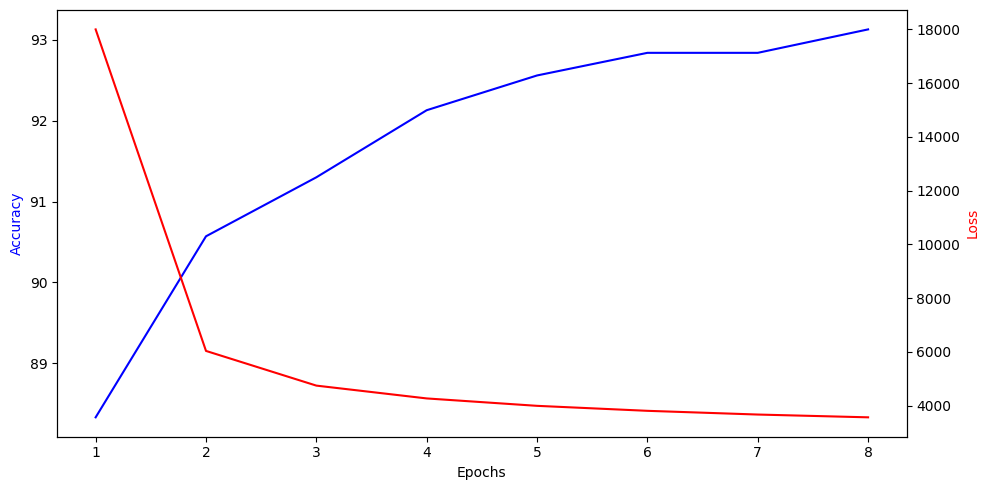

In [62]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(range(1, epochs+1), accuracies, 'b-', label='Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='b')

ax2 = ax1.twinx()
ax2.plot(range(1, epochs+1), losses, 'r-', label='Loss')
ax2.set_ylabel('Loss', color='r')

fig.tight_layout()
plt.show()


# Student 2
Classic MLP with 2 layers train with hard labels
* MLP Architecture
* Train model
* Test model

In [63]:
student2 = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student2.parameters(), lr=0.001)
epochs = 8

losses = []
accuracies = []

student2.train()

for epoch in range(epochs):
    loss_t = 0
    for data, label in tqdm(loaders['train'], desc = f'Train, Epoch n°{epoch}'):
        optimizer.zero_grad()
        output = student2(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        loss_t += loss.item()
    losses.append(loss_t)
    accuracies.append(test_model(student2))

Test: 100%|██████████| 157/157 [00:04<00:00, 34.50it/s]


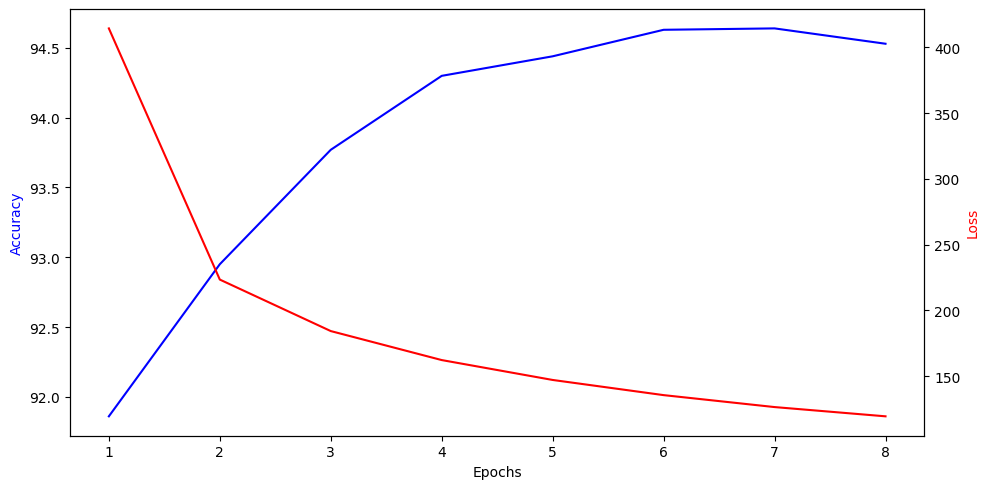

In [64]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(range(1, epochs+1), accuracies, 'b-', label='Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='b')

ax2 = ax1.twinx()
ax2.plot(range(1, epochs+1), losses, 'r-', label='Loss')
ax2.set_ylabel('Loss', color='r')

fig.tight_layout()
plt.show()

In [65]:
print(f"\nStudent2 accuracy on test dataset: {test_model(student2)}%")

Test: 100%|██████████| 157/157 [00:04<00:00, 37.04it/s]


Student2 accuracy on test dataset: 94.53%


# Accuracy by parameter
The teacher model have 21840 parameters.  
We will build and evaluate different MLP model structures to see how the number of parameters influences the accuracy of our models.  
Number of parameters : 7840, 9k, 10k, 11k, 12k, 13k, 14k, 15k, 16k, 17k, 18k, 19k, 20k, 21k

Notre MLP possède deux couches, la première couche d'entrée et la dernière couche de sortie possèdent des tailles fixes respectivemet 784 et 10.  
Nous ne pouvons donc jouer uniqueemnt sur une valeur.  
Le calcul du nombre de paramètres est donc le suivant :  
nb_param = 784 * x + x * 10 (avec x un entier)  
=> nb_param = x * (784 + 10) = 794 * x  
=> x = nb_param / 794  

Par exemple, pour nb_param = 7840  
x = 7840 / 794 = 9.87 = 10

In [66]:
nb_param = [7840, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000]

In [67]:
x = [int(i/794)+1 for i in nb_param]

In [68]:
class MLP(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.l1 = nn.Linear(784, size)
        self.l2 = nn.Linear(size, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = torch.tanh(x)
        x = self.l2(x)
        return x

In [ ]:
accuracies = []

for i, p in enumerate(x):
    model = MLP(p)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 8

    model.train()
    print(f"Train model with {nb_param[i]} parameters")
    for epoch in range(epochs):
        for data, _ in tqdm(loaders['train'], desc = f'Train, Epoch n°{epoch}'):
            optimizer.zero_grad()
            output_teacher = teacher(data)
            output_student = model(data)
            loss = criterion(output_student, output_teacher)
            loss.backward()
            optimizer.step()
    accuracies.append(test_model(model))

Train model with 7840 parameters


Test: 100%|██████████| 157/157 [00:05<00:00, 28.74it/s]


Train model with 9000 parameters


Test: 100%|██████████| 157/157 [00:04<00:00, 35.35it/s]


Train model with 10000 parameters


Test: 100%|██████████| 157/157 [00:04<00:00, 32.29it/s]


Train model with 11000 parameters


Test: 100%|██████████| 157/157 [00:05<00:00, 30.43it/s]


Train model with 12000 parameters


Test: 100%|██████████| 157/157 [00:04<00:00, 37.08it/s] 


Train model with 13000 parameters


Test: 100%|██████████| 157/157 [00:05<00:00, 26.60it/s]


Train model with 14000 parameters


Test: 100%|██████████| 157/157 [00:04<00:00, 35.81it/s]


Train model with 15000 parameters


Test: 100%|██████████| 157/157 [00:04<00:00, 34.69it/s]


Train model with 16000 parameters


Test: 100%|██████████| 157/157 [00:04<00:00, 33.49it/s]


Train model with 17000 parameters


Test: 100%|██████████| 157/157 [00:04<00:00, 32.94it/s] 


Train model with 18000 parameters


Test: 100%|██████████| 157/157 [00:05<00:00, 27.40it/s]


Train model with 19000 parameters


Test: 100%|██████████| 157/157 [00:04<00:00, 36.08it/s]


Train model with 20000 parameters


Test: 100%|██████████| 157/157 [00:04<00:00, 33.47it/s]


Train model with 21000 parameters


Train, Epoch n°3:  25%|██▍       | 230/938 [00:11<00:42, 16.85it/s]

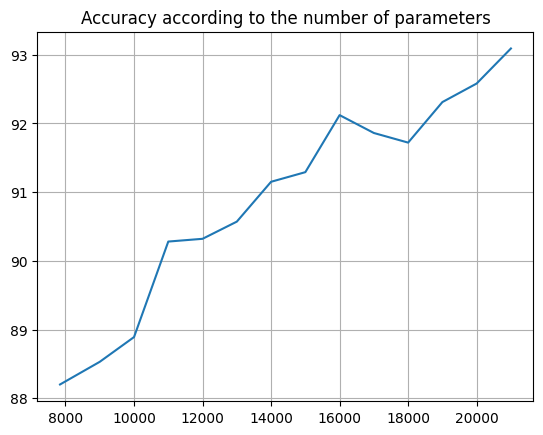

In [71]:
plt.plot(nb_param, accuracies)

plt.title('Accuracy according to the number of parameters')
plt.grid()
plt.show()